In [17]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import zipfile
import shutil
import os
import kagglehub
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend as K, Sequential
from keras import utils
from keras.api.models import Model
from keras.api.layers import Input
from keras.api.regularizers import l2
from keras.api.layers import Activation
from keras.api.layers import Dense, Lambda, MaxPooling2D
from keras.api.utils import get_file
from keras.api.optimizers import Lion
from keras.api.losses import categorical_focal_crossentropy
from keras.api.utils import plot_model
from keras.api.layers import Conv2D
from keras.api.layers import GlobalAveragePooling2D
from keras.api.layers import GlobalMaxPool2D
from keras.api.layers import GlobalMaxPooling2D
from keras.api.layers import concatenate, add
from keras.api.utils import get_source_inputs
from keras.api.layers import BatchNormalization
# from tensorflow.compat.v1.keras.utils import convert_all_kernels_in_model
from keras_applications.imagenet_utils import _obtain_input_shape

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [18]:
# Downloading dataset from Kaggle
path = kagglehub.dataset_download("shahidulugvcse/national-flowers")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\bayan\.cache\kagglehub\datasets\shahidulugvcse\national-flowers\versions\1


In [19]:
# The train directory contains directories for each class/flower
train_dir = path + '/flowerdataset/train'
# The test directory contains directories for each class/flower
test_dir = path + '/flowerdataset/test'

# First we need to unzip the file containing lavender test images
with zipfile.ZipFile('./Lavender.zip', 'r') as zip_ref:
    # This extracts the folder into our current working directory
    zip_ref.extractall()

target_dir = test_dir + '/Lavender'
image_dir = './Lavender'

# We get the names of the image files in both directories
target_images = os.listdir(target_dir)
extracted_images = os.listdir(image_dir)

# Now we will replace every image in test/Lavender with our images from ./Lavender
for idx, image_name in enumerate(target_images):
    # Get the full path to the image we want to replace
    image_path = os.path.join(target_dir, image_name)
        
    # Replace the image with our new image
    shutil.copy(image_dir + '/' + str(idx) + '.jpg', image_path)
    
# Remove images in ./Lavender
shutil.rmtree(image_dir)

In [20]:
# Loading the data set

# Some configurations
input_shape = (224, 224)
batch_size = 128
epochs = 50 # Initial estimate that will be refined later

verbose = True
class_names = os.listdir(train_dir) # Getting class names based on directory names as each class' data is in a separate directory
NB_CLASSES = len(class_names)

# Defining a function for loading datasets
# By default it loads a full dataset but you can specify the split and which part of the split you want
def load_dataset(directory, validation_split=0.0, subset='training'):
    if validation_split <= 0.0:
        return utils.image_dataset_from_directory(
            directory=directory,
            label_mode='categorical',
            image_size=input_shape, # Images are resized to the correct dimensions
            pad_to_aspect_ratio=True, # Padding images so as not to lose valuable features & preserve aspect ratio
            seed=123, # Use a seed for reproducibility
            verbose=verbose)
    else:
        return utils.image_dataset_from_directory(
            directory=directory,
            label_mode='categorical',
            image_size=input_shape, # Images are resized to the correct dimensions
            pad_to_aspect_ratio=True, # Padding images so as not to lose valuable features & preserve aspect ratio
            validation_split=validation_split,
            subset=subset,
            seed=123, # Use a seed for reproducibility
            verbose=verbose)

# Loading our training dataset using a 0.2 split and the training subset means we will take the 80% part
train_ds = load_dataset(train_dir, validation_split=0.2, subset='training')

# Loading the remainder of our training dataset as our validation dataset
valid_ds = load_dataset(train_dir, validation_split=0.2, subset='validation')

# Loading our testing dataset, by excluding a specified validation split we take the whole dataset
test_ds = load_dataset(test_dir)

Found 3600 files belonging to 9 classes.
Using 2880 files for training.
Found 3600 files belonging to 9 classes.
Using 720 files for validation.
Found 881 files belonging to 9 classes.


In [21]:
# Min-max normalisation
# x represents image data so we divide it by 255 to normalise each image's pixel values
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
valid_ds = valid_ds.map(lambda x, y: (x / 255.0, y))

### 2.2 ResNeXt
#### Weight Initialization
ResNext uses the Keras he normal initializer to initialize their model weights. Weights get sampled from a normal distribution centered on 0 and a standard deviation that is dependent on the input shape (source: https://keras.io/api/layers/initializers/).

#### Activation Functions
ResNext mainly uses ReLU as an activation function and Softmax for the final output.

##### ReLU (Rectified Linear Unit)
The ReLU returns its input, if it's non-negative. As most of the activation functions, it introduces non-linearity that ensures that the model can deal with complex data. Compared to other activation functions that are used in hidden layers, it prevents the problem of vanishing gradients.
* Formula: f(x) = max(0, x)

##### Softmax:
In the last layer, by using the softmax activation function both architectures ensure that the output can be interpreted as probabilities for the different classification classes. It ensures values between 0 and 1 for each output, that in sum add up to 1.
* Formula: p(i) = exp(x(i)) / (exp(x(1)) + exp(x(2)) + … + exp(x(n)))
* Where p(i) is the probability of the ith class, x(i) is the ith input into the activation function and n is the number of inputs into the activation function
* exp means the exponential function 

#### Batch Normalization 
Batch Normalization was originally introduced to solve the vanishing and exploding gradients problem during training, where other solutions mainly offer improvements at the beginning of the training (such as ReLU or He initialization). It improves accuracy and decreases sensitivity to the weight initialization. An additional benefit is that it works as a regularizer against overfitting (= increasing generalizability). In the ResNext model it is applied before the activation function of each layer. During training, batch normalization works by calculating a common mean and standard deviation of a batch, z-transforming all data in the batch and then applying a scaling and an offset, both of which are also adapted (learned) during the learning phase. Additionally, a mean and standard deviation across all batches are learned and can be applied after training, when the model is applied to the test data. Source: Géron, A. (2019). Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow: Concepts, tools, and techniques to build intelligent systems (Second edition). O’Reilly Media, Inc.

#### Regularization
o	Generally, Regularization helps to reduce the risk of overfitting to the training data. Besides Batch Normalization, that offers regularization as a side benefit, ResNext also uses L2-Regularization in all its convolutional layers. At each training step a regularization loss is calculated. This is then added to the originally calculated loss. The regularization loss is computed by multiplying the weight decay parameter with the sum across all squared weights of the model. This penalizes large weight values. Source: https://www.geeksforgeeks.org/l1l2-regularization-in-pytorch/#concept-of-l2-regularization

#### Hyperparameters
##### External Hyperparameters
* Input Shape: Determined by the decision what size the images get resized to during preprocessing (in the Dataset loading functionality of Keras); 
* Depth: Number of layers (or blocks, depending on whether a single number or an array is provided) in the network model; Opting for a higher depth would mean adding additional bottleneck blocks which themselves contain the group convolution blocks; 
* Cardinality (unique to ResNext): Number of groups that get processed in parallel within the group convolution; The paper shows that increasing cardinality can improve accuracy while maintaining complexity and it shows to be more effective than increasing depth or width. Source: Xie, S., Girshick, R., Dollár, P., Tu, Z., & He, K. (2017). Aggregated Residual Transformations for Deep Neural Networks. 2017 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 5987–5995. https://doi.org/10.1109/CVPR.2017.634
* Width: number of filters per group within the group convolution, controls the number of “simple transformations” (inner product as we’re used to from simple neurons)
* Weight Decay (L2 Regularization): Controls how much large weights are penalized
* Weights (pretrained model or not) / include_top: Determine whether pretrained weights (in this case just pre-trained weights of the cifar-10 training set) will be used for initialization; include_top refers to whether the final layer will be included
* Loss function: Function that determines how the difference between the prediction of the model and the actual classification of a specific input will be operationalized
* Optimizer: Function that determines how the loss function will be used to adapt weights within the model and thus learn
* Metrics: Used to evaluate the model (during training to track progress and after training on the test dataset)

##### Internal Hyperparameters
Mostly not intended to be changed: Part of the internal ResNeXt Code
* Padding: Defined for a single layer (although the same across all layers), whether input is padded so that the output size isn’t reduced merely by using a filter of a non-zero dimensionality
* Filter size: Defined for a single layer, defines the size of the window of the input that is convoluted
* Filter number: Defined for a single layer, determines the number of the output feature maps
* Strides: Defined for a single layer, determines how the Kernel moves across the input (the step sizes).
* Kernel initializer: Defined for a single layer (although it should be the same across all layers), determines how the weights within the kernels of one layer are initialized prior to training
* Kernel regularizer: Defined for a single layer (although it should be the same across all layers), determines if a L1 or L2 regularizer is used. Both adapt the loss function by penalizing weights, for better generalizability of the training results
* Activation function: Defined for a single layer (although it should usually be the same across all layers except from the output layer(s)). This determines how non-linearity is introduced into the model by applying a non-linear function to the data.

#### Unique Features of ResNeXt
##### Residual Learning (or "Skip connections")
It’s a solution for vanishing / exploding gradients during backpropagation in deep networks. In ResNext (and other architectures using residual learning), the output activation of one layer is added to the output of another layer while skipping intermediate layers. Training will be sped up by this, since the network doesn’t have to “wait” for all layers to have started learning to make progress. However, both outputs need to have the same shape and thus the output of the earlier layer might need to be modified (which is done by a 1x1 Convolution in ResNext). Sources: https://www.geeksforgeeks.org/residual-networks-resnet-deep-learning/ and Géron, A. (2019). Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow: Concepts, tools, and techniques to build intelligent systems (Second edition). O’Reilly Media, Inc.

#### Group Convolution
In ResNext, there is a “split-transform-merge” strategy (because input channels are split into groups and independently convoluted before being combined into an overall output) that can also be observes in Inception modules (which are used in GoogleLeNet). However, Inception modules are hard to design, because adaptation of many factors and hyperparameters is necessary. ResNext on the other hand uses the same topology in all of the paths, which reduces the hyperparameters needed and makes the number of paths an investigable parameter. Source: Xie, S., Girshick, R., Dollár, P., Tu, Z., & He, K. (2017). Aggregated Residual Transformations for Deep Neural Networks. 2017 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 5987–5995. https://doi.org/10.1109/CVPR.2017.634

#### Modularization
There is one main building block (Bottleneck block) that is repeated, which leads to a simple architecture with only few hyperparameters that need to be decided upon and easy extensibility. Source: Xie, S., Girshick, R., Dollár, P., Tu, Z., & He, K. (2017). Aggregated Residual Transformations for Deep Neural Networks. 2017 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 5987–5995. https://doi.org/10.1109/CVPR.2017.634

#### Additional Note
Not unique to ResNext, but an interesting aspect of the architecture is that the bias that is usually also learned in a layer gets omitted in ResNext. This makes sense, since the model makes heavy use of Batch Normalization, which introduces its own learnable shifting parameter. Source: Ioffe, S., & Szegedy, C. (2015). Batch normalization: Accelerating deep network training by reducing internal covariate shift. Proceedings of the 32nd International Conference on International Conference on Machine Learning - Volume 37, 448–456.

In [22]:
# Building the ResNext Model Architecture

CIFAR_TH_WEIGHTS_PATH = ''
CIFAR_TF_WEIGHTS_PATH = ''
CIFAR_TH_WEIGHTS_PATH_NO_TOP = ''
CIFAR_TF_WEIGHTS_PATH_NO_TOP = ''

IMAGENET_TH_WEIGHTS_PATH = ''
IMAGENET_TF_WEIGHTS_PATH = ''
IMAGENET_TH_WEIGHTS_PATH_NO_TOP = ''
IMAGENET_TF_WEIGHTS_PATH_NO_TOP = ''

''' 
Checks requirements and sets up relevant variables before triggering the creation of the network model
Can also load pre-trained weights into the model

Parameters:
- input_shape: shape of the images that are used in training and using (/testing) of the model
- depth: number of layers (or blocks) in the ResNext model
- cardinality: number of independently processed groups in the model
- width: Number of filters produced feature maps per group
- weight_decay: L2 Regularization Penalty
- include_top: determines if the last (dense) layer is included in the model
- weights: can be either cifar10 (pre-trained model weights) or None (which means that they get initialized by the he_normal initializer later)
- input_tensor: existant if there is any input that needs to be passed into the model (e.g. due to previous connected layers / information from pre-training)
- pooling: indicates if average or maximum pooling is used after the first block of the network
- classes: number of output classes for the classification
'''
def ResNext(input_shape=None, depth=29, cardinality=8, width=64, weight_decay=5e-4,
            include_top=True, weights=None, input_tensor=None,
            pooling=None, classes=9):

    # Checks if the weights argument is given correctly (either 'cifar10' for pretrained weights or None for usage of initializers)
    if weights not in {'cifar10', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `cifar10` '
                         '(pre-training on CIFAR-10).')

    # Checks if arguments 'weights', 'include_top' and 'classes' are set consistently -> if the pretrained
    # weights are used and the last layer from the pretrained model should be used, the output classes must be the
    # same as for CIFAR10 (which means that we can't include the last layer if we wanted to use the pre-trained model, 
    # since we only have 9 classes)
    if weights == 'cifar10' and include_top and classes != 10:
        raise ValueError('If using `weights` as CIFAR 10 with `include_top`'
                         ' as true, `classes` should be 10')

    # If depth is an integer, it indicates the overall number of layers in the model, that need to be equally assigned
    # to the blocks used in the model. To be able to achieve that, depth must be dividable by 9 after the 
    # input and output layer were deducted from the depth
    if type(depth) == int:
        if (depth - 2) % 9 != 0:
            raise ValueError('Depth of the network must be such that (depth - 2)'
                             'should be divisible by 9.')

    # validation of the input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=256,
                                      min_size=8,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    # Creates placeholder input of the specified shape if no specified tensor needs to be inputted into the model
    if input_tensor is None:
        img_input = Input(shape=input_shape)
    # If there is a specified input tensor that is provided, if it's a keras tensor, it is used directly
    # Otherwise a keras tensore gets instaniated with the specified content
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    # Triggers creation of the model (output)
    x = __create_res_next(classes, img_input, include_top, depth, cardinality, width,
                          weight_decay, pooling)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Creates Keras model
    model = Model(inputs, x, name='resnext')

    # If the weights are initialized with the cifar-10 pre-trained weights, then
    # the following block applies, otherwise the model is returned.
    if weights == 'cifar10':
        # If depth, cardinality and width are the same as during pre-training, the weights can be applied
        # Otherwise there would be a mismatch between given, pre-trained weights and model weights in the newly created model
        if (depth == 29) and (cardinality == 8) and (width == 64):
            # Check where in the input shape the channels are specified and stored
            # Depending on that, get weights stored in the same format 
            # which one needs to be taken is specified by having different file paths to the different storage versions
            # This is the same for the model with or without the last layer (and thus the corresponding weights)
            if K.image_data_format() == 'channels_first':
                if include_top:
                    weights_path = get_file('resnext_cifar_10_8_64_th_dim_ordering_th_kernels.h5',
                                            CIFAR_TH_WEIGHTS_PATH,
                                            cache_subdir='models')
                else:
                    weights_path = get_file('resnext_cifar_10_8_64_th_dim_ordering_th_kernels_no_top.h5',
                                            CIFAR_TH_WEIGHTS_PATH_NO_TOP,
                                            cache_subdir='models')

                # weights are loaded from the specified path (that belongs to weights stored in the  
                # channel-first format and with ot without the last network layer as specified)
                model.load_weights(weights_path)

                # Converts the convolution kernels / weights in the model from Theano to TensorFlow
                if K.backend() == 'tensorflow':
                    warnings.warn('Warning')
                    convert_all_kernels_in_model(model)
            else:
                if include_top:
                    weights_path = get_file('resnext_cifar_10_8_64_tf_dim_ordering_tf_kernels.h5',
                                            CIFAR_TF_WEIGHTS_PATH,
                                            cache_subdir='models')
                else:
                    weights_path = get_file('resnext_cifar_10_8_64_tf_dim_ordering_tf_kernels_no_top.h5',
                                            CIFAR_TF_WEIGHTS_PATH_NO_TOP,
                                            cache_subdir='models')

                # weights are loaded from the specified path (that belongs to weights stored in the
                # channel-last format and with ot without the last network layer as specified)
                model.load_weights(weights_path)

                # Converts the convolution kernels / weights in the model to Theano
                if K.backend() == 'theano':
                    convert_all_kernels_in_model(model)

    return model


''' 
Defines first higher-level block in the architecture (block 0) that performs one 2D Convolution
Parameters: 
- weight_decay: L2 Regularization Penalty
- input: Input to the Convolution
'''
def __initial_conv_block(input, weight_decay=5e-4):
    # channel_axis defines where to find the channel data (in the first position of the single input or in the last position)
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    # Convolution layer with regularization: Kernels of size 3x3 are moved across the image and produce 64 feature maps (one per Kernel)
    # The Kernel is initialized with the h_normal initializer and will learn new weights during training periods; 
    # Kernel_regularizer prevents overfitting (=improves generalizability), more about this separately
    # All of the other Conv2D layers are analogous (with differing number of kernels, kernel sizes and strides), thus will not be described in detail within the code
    x = Conv2D(64, (3, 3), padding='same', use_bias=False, kernel_initializer='he_normal',
               kernel_regularizer=l2(weight_decay))(input)
    # Batach normalization that improved training, more about this separately, the other Batch Normalization layers are analogous, thus will not be described in detail within the code
    x = BatchNormalization(axis=channel_axis)(x)
    # Activation function that introduces non-linearity (more about this separately)
    x = Activation('relu')(x)

    return x

# Not used by us
def __initial_conv_block_imagenet(input, weight_decay=5e-4):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    x = Conv2D(64, (7, 7), padding='same', use_bias=False, kernel_initializer='he_normal',
               kernel_regularizer=l2(weight_decay), strides=(2, 2))(input)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    return x

''' 
Defines important (and distinguishing) component in the architecture (part of higher-order blocks 1 to N)

Parameters:
- input: input into the defined layers
- grouped_channels: number of filters / feature map outputs per independent group
- cardinality: number of independently processed groups in the model
- strides: parameter of the 2D Convolution, determines difference between two kernel positions
- weight_decay: L2 Regularization Penalty
'''
def __grouped_convolution_block(input, grouped_channels, cardinality, strides, weight_decay=5e-4):
    init = input
    # channel_axis defines where to find the channel data (in the first position of the single input or in the last position)
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    # Used to store the outputs for each group that later get combined
    group_list = []

    # There is only one group, standard convolution is applied with Batch normalizationa and a ReLU-activation function
    if cardinality == 1:
        x = Conv2D(grouped_channels, (3, 3), padding='same', use_bias=False, strides=(strides, strides),
                   kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)
        x = BatchNormalization(axis=channel_axis)(x)
        x = Activation('relu')(x)
        return x

    # Cardinality defines the number of independently processed groups; This for loop takes one processing group at a time
    for c in range(cardinality):
        # Defines a Lambda-layer which is used to introduce custom transformations
        # In this layer, the channels of the input get grouped into subsequent groups of size group_channels
        # Where the channels are extracted from in the input depends on if the channel information are stored first or last
        x = Lambda(lambda z: z[:, :, :, c * grouped_channels:(c + 1) * grouped_channels]
        if K.image_data_format() == 'channels_last' else
        lambda z: z[:, c * grouped_channels:(c + 1) * grouped_channels, :, :])(input)

        # 2D convolution gets applied to every channel-group
        x = Conv2D(grouped_channels, (3, 3), padding='same', use_bias=False, strides=(strides, strides),
                   kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(x)

        # The results are stored in a common list
        group_list.append(x)

    # All results of the independent convolutions are combined along the channel_axis dimension to form the final feature map
    group_merge = concatenate(group_list, axis=channel_axis)
    x = BatchNormalization(axis=channel_axis)(group_merge)
    x = Activation('relu')(x)

    return x


'''
Defines component in the architecture (part of higher-order blocks 1 to N)
that makes use of the distinguishing group convolution component and contains residual connections.

Parameters:
- input: input into the defined layers
- filters: Number of kernels for convolution layers and number of Kernels summed up across groups for group convolution layer
- cardinality: number of independently processed groups in the model
- strides: parameter of the 2D Convolution, determines difference between two kernel positions
- weight_decay: L2 Regularization Penalty
'''
def __bottleneck_block(input, filters=64, cardinality=8, strides=1, weight_decay=5e-4):
    init = input

    # Number of kernels / filters for convolution of a single group in the group convolution layer
    grouped_channels = int(filters / cardinality)
    # channel_axis defines where to find the channel data (in the first position of the single input or in the last position)
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    # Number of the filters of init (original input that is later fed back into the model) should be 2*filters argument, otherwise the data is convoluted to contain 2*filters as the output
    # This is important to ensure that init and x have the same shape once they get added together (for the residual connection)
    # Checking at the position of the channel information which is either the first or the last
    if K.image_data_format() == 'channels_first':
        if init.shape[1] != 2 * filters:
            init = Conv2D(filters * 2, (1, 1), padding='same', strides=(strides, strides),
                          use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)
            init = BatchNormalization(axis=channel_axis)(init)
    else:
        if init.shape[-1] != 2 * filters:
            init = Conv2D(filters * 2, (1, 1), padding='same', strides=(strides, strides),
                          use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)
            init = BatchNormalization(axis=channel_axis)(init)

    # first convolution layer within the bottleneck block
    x = Conv2D(filters, (1, 1), padding='same', use_bias=False,
               kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(input)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    # distinguishing component, contains second convolution layer within the bottleneck block
    x = __grouped_convolution_block(x, grouped_channels, cardinality, strides, weight_decay)

    # third convolution layer within the bottleneck block
    x = Conv2D(filters * 2, (1, 1), padding='same', use_bias=False, kernel_initializer='he_normal',
               kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization(axis=channel_axis)(x)

    # Elementwise addition, adds the original input of the bottleneck block to the transformed output
    # from the convolutional layers, including the group convolution (residual connection)
    x = add([init, x])
    x = Activation('relu')(x)

    return x


'''
Creates ResNext architecture (output).
Parameters: 
- nb_classes: Number of output classes; in our case 9 (flower classes that can be differentiated)
- img_input: In our case placeholder with the right input shape
- include_top: Determines whether the output will be a probabilities for the classes or 1D feature maps (number determined by amount of filters in the previous layer)
- depth: number of layers (or blocks) 
- cardinality: number of independently processed groups 
- width: Number of filters produced feature maps per group
- weight_decay: L2 Regularization Penalty
- pooling: indicates if average or maximum pooling is used after the first block of the network
'''
def __create_res_next(nb_classes, img_input, include_top, depth=29, cardinality=8, width=4,
                      weight_decay=5e-4, pooling=None):
    # If depth is a list or a tuple, it's interpreted as a custom specification about the number of bottleneck (-> grouped convolution) blocks per higher-order block
    if type(depth) is list or type(depth) is tuple:
        N = list(depth)
    # Otherwise, if depth is single number, it specifies the overall depth / number of layers of the network
    # In that case a default of 3 higher-order blocks will be defined (additionally to a first and last layer, thus -2 to determine blocks per higher-order block),
    # that are evenly filled with bottleneck (-> grouped convolution) blocks (which all contain 3 Convolution layers -> dividing by 3*3=9)
    else:
        N = [(depth - 2) // 9 for _ in range(3)]

    # Width is the number of feature map outputs / filters per independently processed group, thus the overall amount of filters can be calculated by the following formula
    filters = cardinality * width
    filters_list = []

    # For every higher-order block the number of filters (in the convolutional layers of the bottleneck blocks) is assigned
    # It starts of with the overall width defined by cardinality and per-group width and increases by factor 3 with every higher-order block
    for i in range(len(N)):
        filters_list.append(filters)
        filters *= 2  

    # First higher-order block (block 0, does not use bottleneck block and thus is not counted "properly")
    x = __initial_conv_block(img_input, weight_decay)

    # Higher order block 1 (no downsampling, but bottleneck blocks with the number determined previously by the depth argument)
    for i in range(N[0]):
        x = __bottleneck_block(x, filters_list[0], cardinality, strides=1, weight_decay=weight_decay)

    N = N[1:]  # remove the first block from block definition list, because it was used
    filters_list = filters_list[1:]  # remove the first filter from the filter list, because it was used

    # higher order block 2 to N: While the number of filters doubles with each higher-order block as defined previously, 
    # strides 2 leads to downsampling by factor 2, to ensure computational complexity stays approximately the same
    for block_idx, n_i in enumerate(N):
        for i in range(n_i):
            if i == 0:
                x = __bottleneck_block(x, filters_list[block_idx], cardinality, strides=2,
                                       weight_decay=weight_decay)
            else:
                x = __bottleneck_block(x, filters_list[block_idx], cardinality, strides=1,
                                       weight_decay=weight_decay)

    # If the output layers are included, global average pooling (one average per feature map) is applied 
    # and a dense (fully connected) layer with activation function softmax produces probabilities for the classification output classes
    if include_top:
        x = GlobalAveragePooling2D()(x)
        x = Dense(nb_classes, use_bias=False, kernel_regularizer=l2(weight_decay),
                  kernel_initializer='he_normal', activation='softmax')(x)
    # If the final output layer is not included, pooling is applied according to the pooling-argument
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    return x

In [23]:
# Building the ResNext Model Architecture
import numpy as np

# creates model that accepts images of shape 256x256x3 as input, has 29 convolution layers, 8 independently processed channel-groups int he group convolution and a width of 64 (number of filters)
model = ResNext((224, 224, 3), depth=29, cardinality=8, width=8)

# Compiling the Model, more information on optimizer and loss function separately
model.compile(optimizer=Lion(learning_rate=1e-4), loss=categorical_focal_crossentropy, metrics=['accuracy'])

# Checking Model Summary
model.summary()

Model: "resnext"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 224, 224,  │      1,728 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 224, 224,  │      4,096 │ activation_28[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_29       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_72 (Lambda)  │ (None, 224, 224,  │          0 │ activation_29[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_73 (Lambda)  │ (None, 224, 224,  │          0 │ activation_29[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_74 (Lambda)  │ (None, 224, 224,  │          0 │ activation_29[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_75 (Lambda)  │ (None, 224, 224,  │          0 │ activation_29[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_76 (Lambda)  │ (None, 224, 224,  │          0 │ activation_29[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_77 (Lambda)  │ (None, 224, 224,  │          0 │ activation_29[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_78 (Lambda)  │ (None, 224, 224,  │          0 │ activation_29[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_79 (Lambda)  │ (None, 224, 224,  │          0 │ activation_29[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 224, 224,  │        576 │ lambda_72[0][0]   │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 224, 224,  │        576 │ lambda_73[0][0] 

 Total params: 1,440,192 (5.49 MB)

 Trainable params: 1,427,520 (5.45 MB)

 Non-trainable params: 12,672 (49.50 KB)

In [24]:
plot_model(model, to_file="my_model.png", show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [25]:
# Model Training and eval

history = model.fit(train_ds, epochs=20, validation_data=valid_ds, validation_freq=1)

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1279s 13s/step - accuracy: 0.2718 - loss: 6.6488 - val_accuracy: 0.2597 - val_loss: 6.3801
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1227s 14s/step - accuracy: 0.5091 - loss: 5.8446 - val_accuracy: 0.3069 - val_loss: 5.4616
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1223s 14s/step - accuracy: 0.5798 - loss: 5.1309 - val_accuracy: 0.3000 - val_loss: 4.8086
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1212s 13s/step - accuracy: 0.6181 - loss: 4.4640 - val_accuracy: 0.4097 - val_loss: 4.1170
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1220s 14s/step - accuracy: 0.6293 - loss: 3.8634 - val_accuracy: 0.3944 - val_loss: 3.6020
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1209s 13s/step - accuracy: 0.6665 - loss: 3.3312 - val_accuracy: 0.4208 - val_loss: 3.1107
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1220s 14s/step - accuracy: 0.7050 - loss: 2.8685 - val_accuracy: 0.3847 - val_loss: 2.7251
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1217s 14s/step - accuracy: 0.6933 - loss: 2.4817 - val_accu

In [39]:
model.save('./resnext_models/model.keras')

ImportError: `save_model()` using h5 format requires h5py. Could not import h5py.

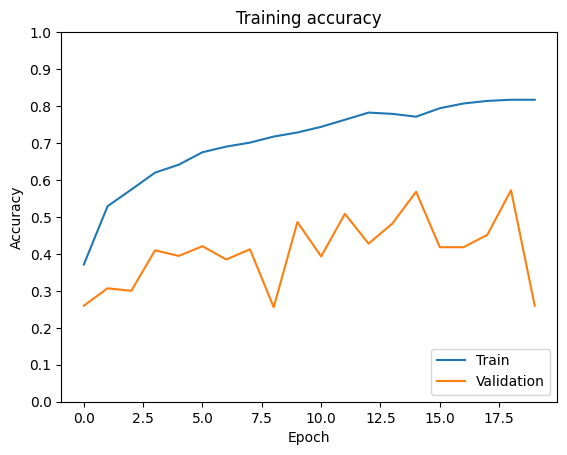

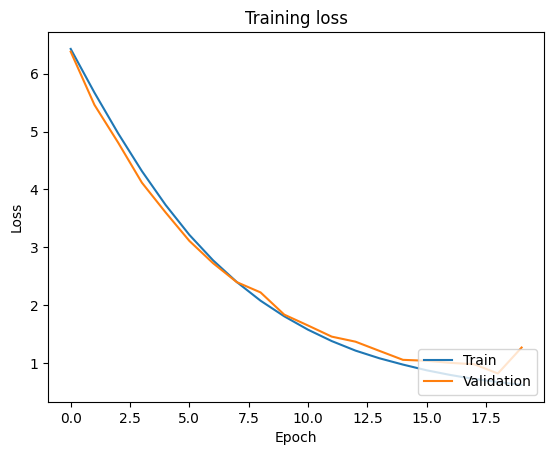

In [42]:
# Plotting accuracy over training
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Plotting loss over training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [43]:
evaluation = model.evaluate(test_ds)
print(f'ResNeXT test loss: {round(evaluation[0], 4)}')
print(f'ResNeXT test accuracy: {round(evaluation[1]*100, 1)}%')

28/28 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.1561 - loss: 3.9347
ResNeXT test loss: 3.9827
ResNeXT test accuracy: 14.4%


In [46]:
# don't keep this cell
X_test = [] # Array of images
y_test = [] # Array of labels corresponding to the images
for x_t, y_t in test_ds:
    for i in range(x_t.shape[0]):
        X_test.append(x_t[i].numpy())
        y_test.append(y_t[i].numpy())
X_test = np.array(X_test)
y_test = np.array(y_test)
# True labels
y_true = np.argmax(y_test, axis=1)

In [50]:
# Get our predictions
resnext_predictions = model.predict(X_test)

28/28 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step


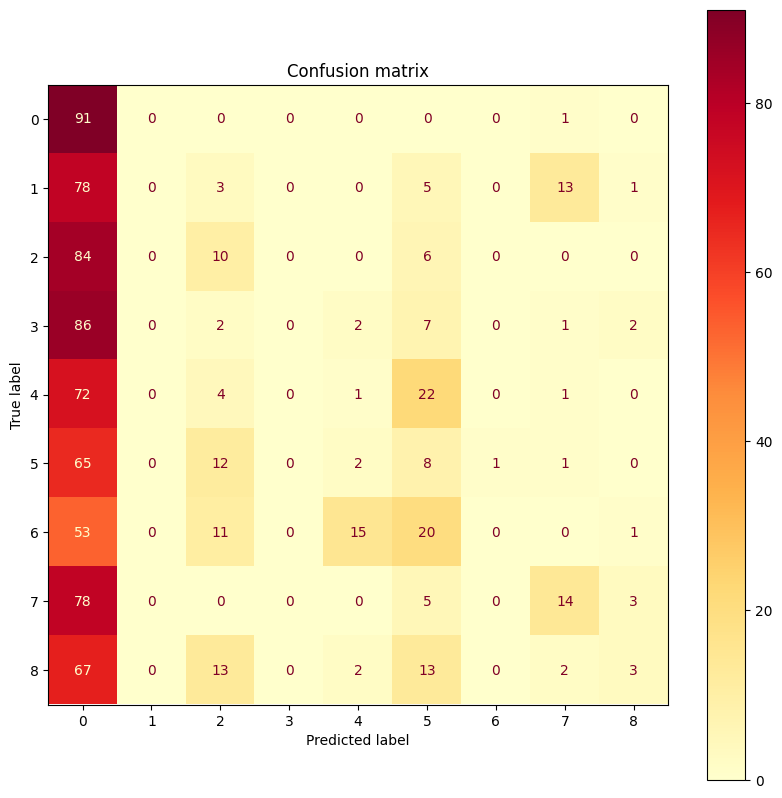

In [51]:
# Computing the confusion matrix using ResNeXT's predictions
resnext_predictions = np.argmax(resnext_predictions, axis=1)
cm = confusion_matrix(y_true, resnext_predictions)
cm_display = ConfusionMatrixDisplay(cm)

fig, ax = plt.subplots(figsize=(10, 10))

# Plotting confusion matrix
cm_display.plot(ax=ax, cmap="YlOrRd")
plt.title("Confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()